Besu IBFT2.0 Log Data Analysis

In [41]:
import pandas as pd
import numpy as np
import csv, warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

def log2csv(log_file: str):
    with open(log_file, 'r') as file:
        lines = file.read().splitlines()
        csv_lines = [x.split(' | ') for x in lines]
        csv_file = log_file.replace('.log', '.csv')
        with open(csv_file, 'w+') as csv_file:
            w = csv.writer(csv_file)
            w.writerows(csv_lines)

def parse_log(log_file: str) -> pd.DataFrame:
    log2csv(log_file)
    csv_file = log_file.replace('.log', '.csv')
    header = ['Timestamp', 'Process', 'LogLevel', 'LogSource', 'Description']
    df_besu = pd.read_csv(csv_file, parse_dates=['Timestamp'], names=header).dropna()
    df_besu['Timestamp'] = pd.to_datetime(df_besu.Timestamp, infer_datetime_format=True, utc=True)
    
    df_ibftround = df_besu[df_besu.LogSource == 'IbftRound']
    df_temp = df_ibftround.loc[:, 'Description'].str.split('\. round=ConsensusRoundIdentifier', expand=True)
    df_ibftround.loc[:, 'Action'] = df_temp[0].values
    df_ibftround.loc[:, 'Order'] = df_temp[1].values
    df_des = df_ibftround.Order.str.split('Sequence=', expand=True)[1].str.split('\, Round=', expand=True)
    df_ibftround.loc[:, 'Sequence'] = df_des[0].astype(int)
    df_ibftround.loc[:, 'Round'] = df_des[1].str.split('\}', expand=True)[0].astype(int)

    df_ibftround.reset_index(inplace=True)
    df_ibftround.drop(columns=['index', 'Description','Order'], axis=1, inplace=True)
    return df_ibftround

def gen_logs_df(logpath, networksize=4):
    df_list = []
    for i in range(networksize):
        log_file = '{}/besu-{}.log'.format(logpath,i+1)
        df = parse_log(log_file)
        df['Node'] = i+1
        df_list.append(df)
    df = pd.concat(df_list)
    return df

def cal_time_delta(send: str, receive: str, df: pd.DataFrame) -> list:
    t_delta_ls = []
    sequences = df.Sequence.unique()
    for seq in sequences:
        df_seq = df.loc[df.Sequence == seq]
        if send in df_seq.Action.unique() and 'proposed' in send:
            c_time = pd.to_datetime(df_seq[df_seq.Action == send].Timestamp.values[0], utc=True)
            df_r = df_seq.loc[df_seq.Action == receive]
            for _, row in df_r.iterrows():
                t_delta = pd.to_datetime(row.Timestamp, utc=True) - c_time
                t_delta_ls.append(t_delta.total_seconds())
        else:
            df_send = df_seq.loc[df_seq.Action == send].sort_values('Timestamp')
            df_receive = df_seq.loc[df_seq.Action == receive].reset_index()
            sendNodes = len(df_send.Node.unique())
            receiveNodes = len(df_receive.Node.unique())
            if sendNodes == receiveNodes or sendNodes+1 == receiveNodes:
                ts = []
                for node in df_receive.Node.unique():
                    t = list(pd.to_datetime(df_receive.loc[df_receive.Node == node].Timestamp.values, utc=True))
                    ts.append(t)
                for _, row in df_send.iterrows():
                    sts = pd.to_datetime(row.Timestamp, utc=True)
                    for i in range(len(ts)):
                        if (row.Node != (i+1)) and ts[i]:
                            rts = ts[i].pop(0)
                            deltatime = (rts - sts).total_seconds()
                            t_delta_ls.append(deltatime)
    return t_delta_ls

# def cal_prep_trans_time(df: pd.DataFrame) -> list:
#     ts_ls = []
#     sequences = df.Sequence.unique()
#     for seq in sequences:
#         df_send = df.loc[(df.Sequence == seq) & (df.Action == 'Sending prepare message')].sort_values('Timestamp')
#         df_receive = df.loc[(df.Sequence == seq) & (df.Action == 'Received a prepare message')].reset_index()
#         if len(df_send.Node.unique())+1 == len(df_receive.Node.unique()):
#             ts = []
#             for node in df_receive.Node.unique():
#                 t = list(pd.to_datetime(df_receive.loc[df_receive.Node == node].Timestamp.values, utc=True))
#                 ts.append(t)
#             for _, row in df_send.iterrows():
#                 sts = pd.to_datetime(row.Timestamp, utc=True)
#                 for i in range(len(ts)):
#                     if (row.Node != (i+1)) and ts[i]:
#                         rts = ts[i].pop(0)
#                         deltatime = (rts - sts).total_seconds()
#                         ts_ls.append(deltatime)
#     return ts_ls

# def cal_commit_trans_time(df: pd.DataFrame) -> list:
#     ts_ls = []
#     sequences = df.Sequence.unique()
#     for seq in sequences:
#         df_send = df.loc[(df.Sequence == seq) & (df.Action == 'Sending commit message')].sort_values('Timestamp')
#         df_receive = df.loc[(df.Sequence == seq) & (df.Action == 'Received a commit message')].reset_index()
#         if len(df_send.Node.unique()) == len(df_receive.Node.unique()):
#             ts = []
#             for node in df_receive.Node.unique():
#                 t = list(pd.to_datetime(df_receive.loc[df_receive.Node == node].Timestamp.values, utc=True))
#                 ts.append(t)
#             for _, row in df_send.iterrows():
#                 sts = pd.to_datetime(row.Timestamp, utc=True)
#                 for i in range(len(ts)):
#                     if (row.Node != (i+1)) and ts[i]:
#                         rts = ts[i].pop(0)
#                         deltatime = (rts - sts).total_seconds()
#                         ts_ls.append(deltatime)
#     return ts_ls

def cal_process_time(df):
    t_process_proposal, t_process_prepare, t_process_commit = [], [], []
    sequences = df.Sequence.unique()
    for seq in sequences:
        df_seq = df.loc[df.Sequence == seq]
        for _, row in df_seq.iterrows():
            if row.Action == 'Received a proposal message':
                rts_prop = pd.to_datetime(row.Timestamp, utc=True)
                continue
            if row.Action == 'Sending prepare message':
                sts_prep = pd.to_datetime(row.Timestamp, utc=True)
                t_process_proposal.append((sts_prep - rts_prop).total_seconds())
            if row.Action == 'Received a prepare message':
                rts_prep = pd.to_datetime(row.Timestamp, utc=True)
                continue
            if row.Action == 'Sending commit message':
                sts_commit = pd.to_datetime(row.Timestamp, utc=True)
                t_process_prepare.append((sts_commit - rts_prep).total_seconds())
            if row.Action == 'Received a commit message':
                rts_commit = pd.to_datetime(row.Timestamp, utc=True)
                continue
            if row.Action == 'Importing block to chain':
                sts_import = pd.to_datetime(row.Timestamp, utc=True)
                t_process_commit.append((sts_import - rts_commit).total_seconds())
    return t_process_proposal, t_process_prepare, t_process_commit

def plot_hist(ts, ax=None, upper=50, title='Frequency Histogram'):
    ax = ax or plt.gca()
    x = [1000*t for t in ts if t>0 and 1000*t<upper]
    hist = ax.hist(x, bins=50)
    ax.set(title=title, xlabel='Transmit Time (ms)', ylabel='Frequency')
    return hist

In [15]:
log_path1 = '../data/logs-20211215-141843-4c-8gb'
df1 = gen_logs_df(logpath=log_path1)
log_path2 = '../data/logs-20211215-154842-2c-4gb'
df2 = gen_logs_df(logpath=log_path2)
log_path3 = '../data/logs-20211215-171026-8c-8gb'
df3 = gen_logs_df(logpath=log_path3)

In [29]:
df1.loc[df1.Sequence == 2]

,Timestamp,Process,LogLevel,LogSource,Action,Sequence,Round,Node
7,2021-12-15 20:10:45.027000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a proposal message,2,0,1
8,2021-12-15 20:10:45.034000+00:00,pool-9-thread-1,DEBUG,IbftRound,Sending prepare message,2,0,1
9,2021-12-15 20:10:45.046000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a prepare message,2,0,1
10,2021-12-15 20:10:45.047000+00:00,pool-9-thread-1,DEBUG,IbftRound,Sending commit message,2,0,1
11,2021-12-15 20:10:45.056000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a prepare message,2,0,1
12,2021-12-15 20:10:45.059000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a commit message,2,0,1
13,2021-12-15 20:10:45.066000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a commit message,2,0,1
14,2021-12-15 20:10:45.067000+00:00,pool-9-thread-1,DEBUG,IbftRound,Importing block to chain,2,0,1
7,2021-12-15 20:10:45.012000+00:00,pool-9-thread-1,DEBUG,IbftRound,Creating proposed block,2,0,2
8,2021-12-15 20:10:45.039000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a prepare message,2,0,2


In [ ]:
ts_pro_trans_4c8gb = cal_time_delta(send='Creating proposed block', receive='Received a proposal message', df=df1)
ts_pro_trans_2c4gb = cal_time_delta(send='Creating proposed block', receive='Received a proposal message', df=df2)
ts_pro_trans_8c8gb = cal_time_delta(send='Creating proposed block', receive='Received a proposal message', df=df3)

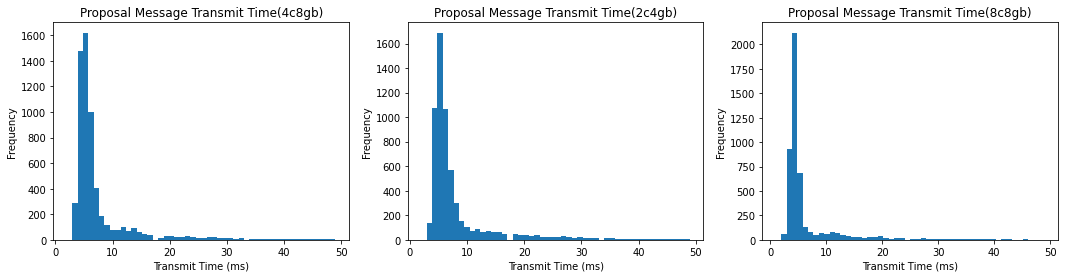

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
title = 'Proposal Message Transmit Time'
plot_hist(ts_pro_trans_4c8gb, axs[0], 50, title+'(4c8gb)')
plot_hist(ts_pro_trans_2c4gb, axs[1], 50, title+'(2c4gb)')
plot_hist(ts_pro_trans_8c8gb, axs[2], 50, title+'(8c8gb)')

plt.show()

In [32]:
# ts_prep_trans_4c8gb = cal_prep_trans_time(df1)
# ts_prep_trans_2c4gb = cal_prep_trans_time(df2)
# ts_prep_trans_8c8gb = cal_prep_trans_time(df3)

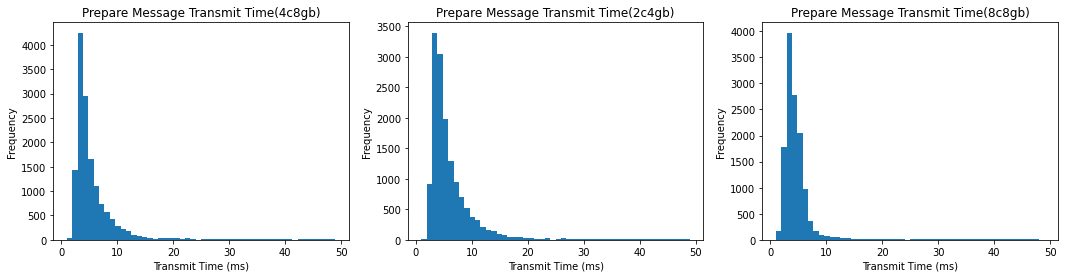

In [42]:
send_str, receive_str = 'Sending prepare message', 'Received a prepare message'
ts_prep_trans_4c8gb = cal_time_delta(send=send_str, receive= receive_str, df=df1)
ts_prep_trans_2c4gb = cal_time_delta(send=send_str, receive= receive_str, df=df2)
ts_prep_trans_8c8gb = cal_time_delta(send=send_str, receive= receive_str, df=df3)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
title = 'Prepare Message Transmit Time'
plot_hist(ts_prep_trans_4c8gb, axs[0], 50, title+'(4c8gb)')
plot_hist(ts_prep_trans_2c4gb, axs[1], 50, title+'(2c4gb)')
plot_hist(ts_prep_trans_8c8gb, axs[2], 50, title+'(8c8gb)')

plt.show()

In [ ]:
# ts_commit_trans_4c8gb = cal_commit_trans_time(df1)
# ts_commit_trans_2c4gb = cal_commit_trans_time(df2)
# ts_commit_trans_8c8gb = cal_commit_trans_time(df3)

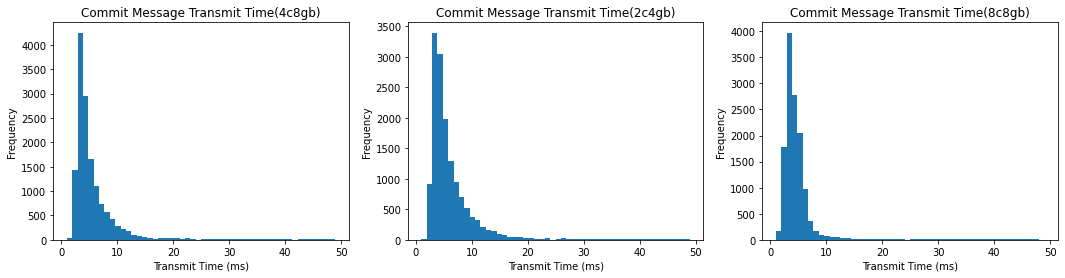

In [43]:
send_str, receive_str = 'Sending commit message', 'Received a commit message'
ts_commit_trans_4c8gb = cal_time_delta(send=send_str, receive= receive_str, df=df1)
ts_commit_trans_2c4gb = cal_time_delta(send=send_str, receive= receive_str, df=df2)
ts_commit_trans_8c8gb = cal_time_delta(send=send_str, receive= receive_str, df=df3)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
title = 'Commit Message Transmit Time'
plot_hist(ts_prep_trans_4c8gb, axs[0], 50, title+'(4c8gb)')
plot_hist(ts_prep_trans_2c4gb, axs[1], 50, title+'(2c4gb)')
plot_hist(ts_prep_trans_8c8gb, axs[2], 50, title+'(8c8gb)')

plt.show()

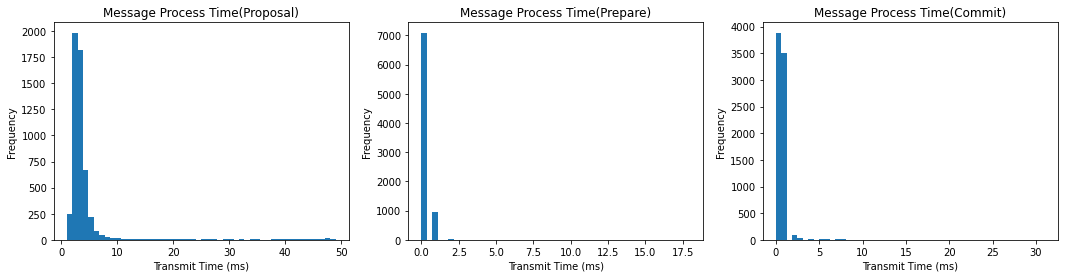

In [28]:
t_process_proposal, t_process_prepare, t_process_commit = cal_process_time(df1)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
title = 'Message Process Time'
plot_hist(t_process_proposal, axs[0], 50, title+'(Proposal)')
plot_hist(t_process_prepare, axs[1], 50, title+'(Prepare)')
plot_hist(t_process_commit, axs[2], 50, title+'(Commit)')

plt.show()

Scipy Fits Commit Transmit Time

In [52]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

def plot_fitting(ts, threshold, title):
    # Load data from statsmodels datasets
    # data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())
    data = pd.Series([1000*t for t in ts if t > 0 and 1000*t <= threshold])
    # Plot for comparison
    plt.figure(figsize=(12,8))
    ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

    # Save plot limits
    dataYLim = ax.get_ylim()

    # Find best fit distribution
    best_distibutions = best_fit_distribution(data, 200, ax)
    best_dist = best_distibutions[0]

    # Update plots
    ax.set_ylim(dataYLim)
    ax.set_title(u'{}.\n All Fitted Distributions'.format(title))
    ax.set_xlabel(u'Time (ms)')
    ax.set_ylabel('Frequency')

    # Make PDF with best params 
    pdf = make_pdf(best_dist[0], best_dist[1])

    # Display
    plt.figure(figsize=(12,8))
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

    param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
    dist_str = '{}({})'.format(best_dist[0].name, param_str)

    ax.set_title(u'{} with Best Fit Distribution \n {}'.format(title,dist_str))
    ax.set_xlabel(u'Time (ms)')
    ax.set_ylabel('Frequency')

  1 / 104: ksone
  2 / 104: kstwo
  3 / 104: kstwobign
  4 / 104: norm
  5 / 104: alpha
  6 / 104: anglit
  7 / 104: arcsine
  8 / 104: beta
  9 / 104: betaprime
 10 / 104: bradford
 11 / 104: burr
 12 / 104: burr12
 13 / 104: fisk
 14 / 104: cauchy
 15 / 104: chi
 16 / 104: chi2
 17 / 104: cosine
 18 / 104: dgamma
 19 / 104: dweibull
 20 / 104: expon
 21 / 104: exponnorm
 22 / 104: exponweib
 23 / 104: exponpow
 24 / 104: fatiguelife
 25 / 104: foldcauchy
 26 / 104: f
 27 / 104: foldnorm
 28 / 104: weibull_min
 29 / 104: weibull_max
 30 / 104: genlogistic
 31 / 104: genpareto
 32 / 104: genexpon
 33 / 104: genextreme
 34 / 104: gamma
 35 / 104: erlang
 36 / 104: gengamma
 37 / 104: genhalflogistic
 38 / 104: genhyperbolic
 39 / 104: gompertz
 40 / 104: gumbel_r
 41 / 104: gumbel_l
 42 / 104: halfcauchy
 43 / 104: halflogistic
 44 / 104: halfnorm
 45 / 104: hypsecant
 46 / 104: gausshyper
 47 / 104: invgamma
 48 / 104: invgauss
 49 / 104: geninvgauss
 50 / 104: norminvgauss
 51 / 104: 

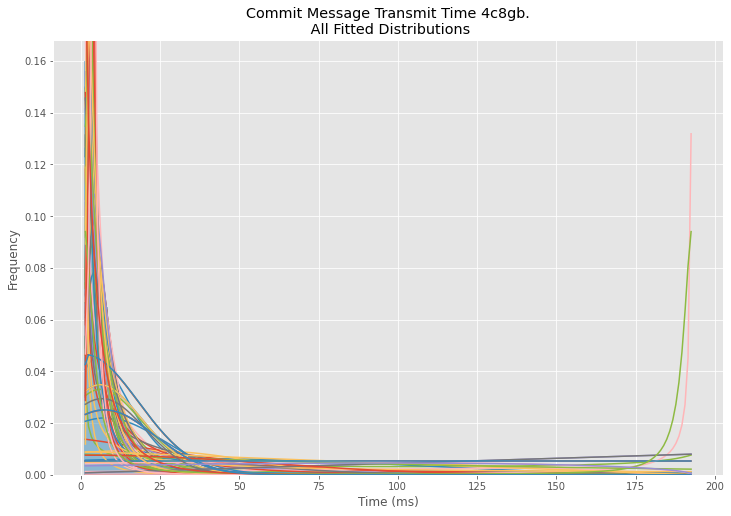

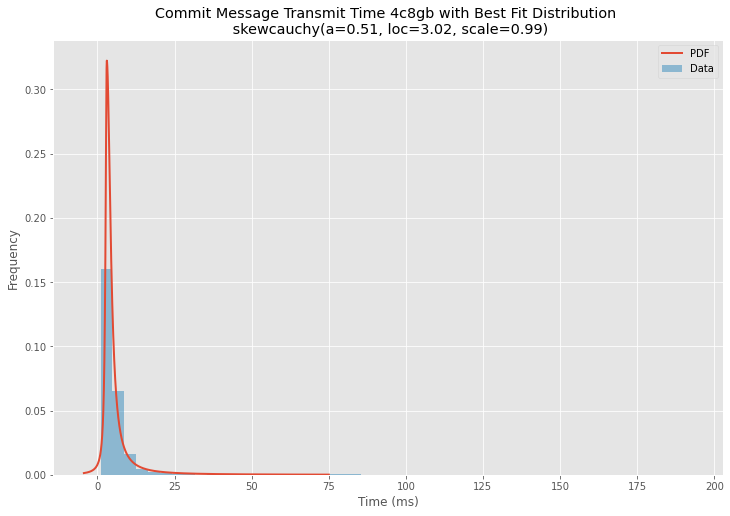

In [53]:
plot_fitting(ts_commit_trans_4c8gb, 200, 'Commit Message Transmit Time 4c8gb')

In [54]:
data = pd.Series([1000*t for t in ts_commit_trans_4c8gb if t > 0 and 1000*t <= 200])
len(data)

13713

In [55]:
st.kstest(data, 'skewcauchy', (0.51, 3.02, 0.99), len(data))

KstestResult(statistic=0.19291523164421684, pvalue=0.0)